In [1]:
%matplotlib inline
from typing import List, Union
from operator import itemgetter
import warnings

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import torch.nn as nn
import torchaudio
import scipy
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_sequence, pack_padded_sequence, pad_packed_sequence
import pandas as pd
import seaborn as sns
import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from scipy import signal
import zarr

from ipywidgets import interactive
from IPython.display import Audio, display

## CinC2020 Dataset

In [2]:
from datasets import CinC2020

In [3]:
ds = CinC2020(set_seq_len=5000, fs=500, clean_signal=True)
p_signal, sampling_rate, age, sex, dx = ds[0]
p_signal, sampling_rate, age, sex, dx

(array([[ 0.00023028,  0.0015427 ,  0.00132405, ...,  0.01512091,
         -0.00923978, -0.00637499],
        [ 0.000211  ,  0.00056434,  0.00040496, ...,  0.02023743,
         -0.00940781, -0.0072829 ],
        [ 0.00019173, -0.00042402, -0.00053412, ...,  0.02484411,
         -0.00953574, -0.00814077],
        ...,
        [-0.01050244, -0.01771826, -0.00795653, ..., -0.0322378 ,
         -0.0084096 ,  0.00053057],
        [-0.00995213, -0.01562813, -0.00627436, ..., -0.02894913,
         -0.00722838,  0.00120927],
        [-0.00947202, -0.01347868, -0.00444271, ..., -0.02532123,
         -0.00600689,  0.00196797]], dtype=float32),
 500,
 array(53.),
 array(0.),
 164867002)

In [4]:
# display(Audio(data=p_signal[:,0], rate=sampling_rate))
iter_ds = iter(ds)

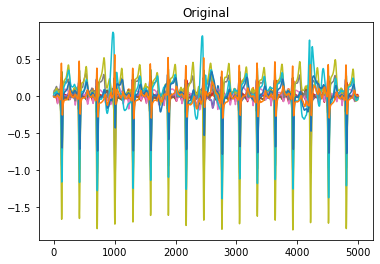

In [5]:
p_signal, sampling_rate, age, sex, dx = next(iter_ds)
# while np.max(p_signal) < 10:
#     p_signal, sampling_rate, age, sex, dx = next(iter_ds)

plt.figure()
plt.title(f"Original")
plt.plot(p_signal)
plt.show()

specgram.shape torch.Size([12, 26, 201])


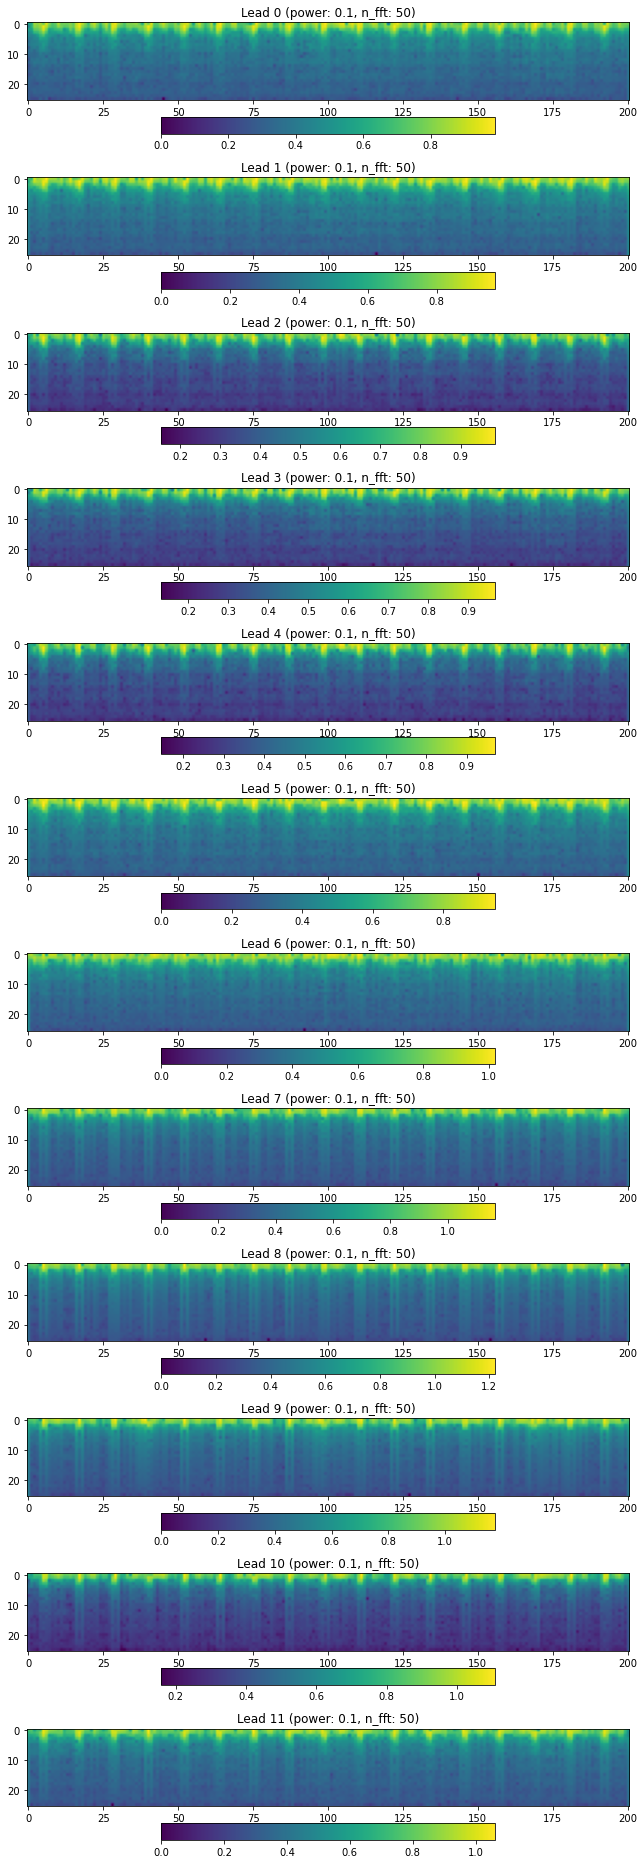

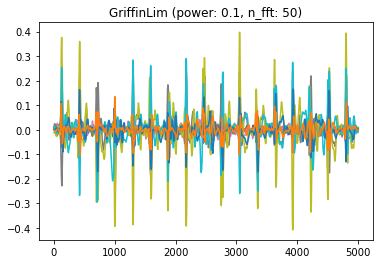

In [6]:
n_fft = 50

# power
power = 0.1

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    n = torchaudio.transforms.Spectrogram(
        n_fft = n_fft,
        power = power,
        normalized=True
    )
    specgram = n(torch.Tensor(p_signal.T))
    print("specgram.shape", specgram.shape)
    rn = torchaudio.transforms.GriffinLim(n_fft = n_fft, power = power)
    recon = rn(specgram)


fig, axs = plt.subplots(12, 1, figsize=(10, 26))
# plt.imshow(specgram[0,:,:].log2().numpy())
for i in range(12):
    axs[i].set_title(f"Lead {i} (power: {power}, n_fft: {n_fft})")
    pcm = axs[i].imshow(specgram[i,:,:].numpy())
    fig.colorbar(pcm, orientation="horizontal", ax=axs[i])
#     axs[i].colorbar()
fig.tight_layout()
plt.show()

plt.figure()
plt.title(f"GriffinLim (power: {power}, n_fft: {n_fft})")
plt.plot(recon.T)
plt.show()

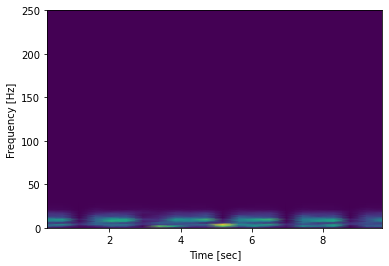

In [7]:
f, t, Sxx =signal.spectrogram(p_signal[:, 0], fs=sampling_rate)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## Debugging NN Architecture

In [8]:
p_signal, sampling_rate, age, sex, dx = next(iter(DataLoader(ds, batch_size=3)))

p_signal.shape, sampling_rate, age, sex, dx

(torch.Size([3, 5000, 12]),
 tensor([500, 500, 500]),
 tensor([53., 70., 70.], dtype=torch.float64),
 tensor([0., 1., 1.], dtype=torch.float64),
 tensor([164867002, 164861001, 164861001]))

In [9]:
class View(nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [10]:
x = torch.transpose(p_signal, 1, 2)
n_fft = 50
power = 0.1

enc = nn.Sequential(
    # torch.Size([b, 12, 26, 201])
    nn.Conv2d(12, 12, (26, 5)),
    nn.Softplus()
)

print("encoder params", sum(dict((p.data_ptr(), p.numel()) for p in enc.parameters()).values()))

dec = nn.Sequential(
    nn.ConvTranspose2d(12, 12, (26, 5)),
    nn.Sigmoid()
)
# 12 * 26 * 201 = 62712
print("decoder params", sum(dict((p.data_ptr(), p.numel()) for p in dec.parameters()).values()))

# encoding forward
print("before spectrogram shape:", x.shape)
samp_in = torchaudio.transforms.Spectrogram(n_fft=n_fft, power=power, normalized=True)(x)
print("before encoder tensor shape:", samp_in.shape)
z = enc(samp_in)
print("bottleneck tensor shape:", z.shape)
samp_out = dec(z)
print("after decoding tensor shape:", samp_out.shape)
samp_out = samp_out.view(-1, 12, 26, 201)
print("after unflatten tensor shape:", samp_out.shape)
assert samp_out.shape == samp_in.shape, f"{samp_out.shape} != {samp_in.shape}"


encoder params 18732
decoder params 18732
before spectrogram shape: torch.Size([3, 12, 5000])
before encoder tensor shape: torch.Size([3, 12, 26, 201])
bottleneck tensor shape: torch.Size([3, 12, 1, 197])
after decoding tensor shape: torch.Size([3, 12, 26, 201])
after unflatten tensor shape: torch.Size([3, 12, 26, 201])


torch.Size([3, 12, 26, 201]) tensor(1.2210) tensor(0.)


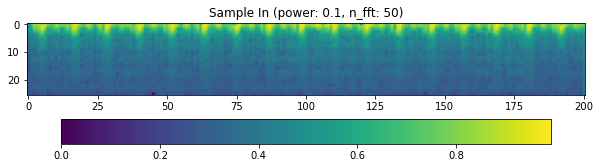

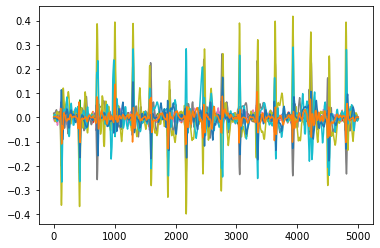

torch.Size([3, 12, 26, 201]) tensor(0.5624, grad_fn=<MaxBackward1>) tensor(0.)


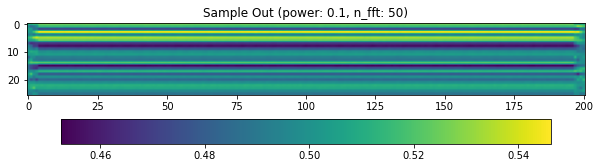

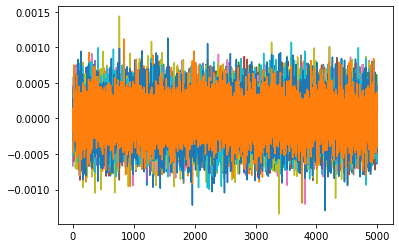

In [11]:
print(samp_in.shape, torch.max(samp_in), torch.min(samp_in))
plt.figure(figsize=(10, 3))

plt.title(f"Sample In (power: {power}, n_fft: {n_fft})")
plt.imshow(samp_in[0, 0, :,:].numpy())
plt.colorbar(orientation="horizontal")
plt.show()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    recon = torchaudio.transforms.GriffinLim(n_fft=n_fft, power=power, normalized=True)(samp_in)

plt.figure()
plt.plot(recon[0, :, :].T)
plt.show()

samp_out = dec(enc(samp_in))
samp_out = samp_out.view(-1, 12, 26, 201)

print(samp_out.shape, torch.max(samp_out), torch.min(samp_in))
plt.figure(figsize=(10, 3))

plt.title(f"Sample Out (power: {power}, n_fft: {n_fft})")
plt.imshow(samp_out[0, 0, :, :].detach().numpy())
plt.colorbar(orientation="horizontal")
plt.show()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    recon = torchaudio.transforms.GriffinLim(n_fft=n_fft, power=power, normalized=True)(samp_out.detach())

plt.figure()
plt.plot(recon[0, :, :].T)
plt.show()


## Investigating Dataset Outliers

In [12]:
ds = CinC2020(set_seq_len=5000, fs=500, clean_signal=True)
dl = DataLoader(ds, batch_size=1, shuffle=True)

count = 0
while True:
    p_signal, sampling_rate, age, sex, dx = next(iter(dl))
    _, _, num_channels = p_signal.shape
    z_batch, z_seq, z_channel = torch.nonzero(p_signal, as_tuple=True)
    break
#     non_zero_channels = torch.unique(z_channel)
#     if len(non_zero_channels) != num_channels:
#         print(p_signal)
#         break
#     else:
#         print(f"count {count}", end="\r")
#     count += 1

torch.Size([1, 5000, 12])


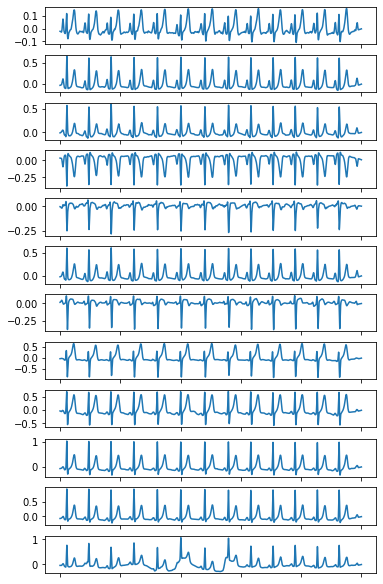

specgram.shape torch.Size([1, 12, 26, 201])
(312, 201)


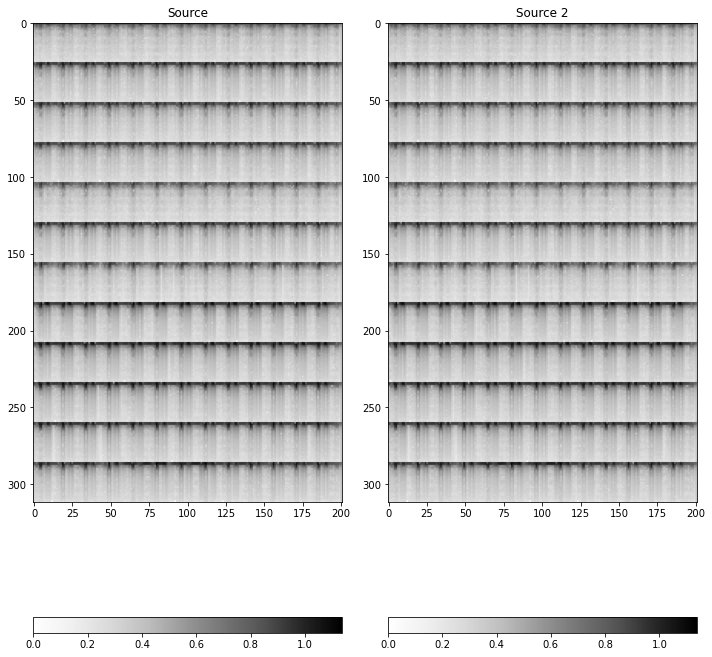

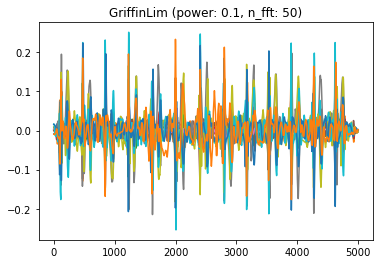

In [13]:
print(p_signal.shape)

# fig, ax = plt.subplots(12, figsize=(5, 8), sharex=True)
# for i in range(12):
#     ax[i].plot(p_signal[0,:,i])
#     ax[i].set_ylabel(None)
# fig.tight_layout()
# plt.show()

sig_fig = plt.figure(constrained_layout=True, figsize=(10, 8))
spec = gridspec.GridSpec(ncols=2, nrows=12, figure=sig_fig)
ax = None
for i in range(12):
    ax = sig_fig.add_subplot(spec[i, 0], sharex=ax)
    ax.set_xticklabels([])
    ax.plot(p_signal[0,:,i])
#     ax[i].set_ylabel(None)
spec.tight_layout(sig_fig)
plt.show()

n_fft = 50

# power
power = 0.1

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    n = torchaudio.transforms.Spectrogram(
        n_fft = n_fft,
        power = power,
        normalized=True
    )
    specgram = n(torch.Tensor(torch.transpose(p_signal, 1, 2)))
    print("specgram.shape", specgram.shape)
    rn = torchaudio.transforms.GriffinLim(n_fft = n_fft, power = power)
    recon = rn(specgram)


# fig, axs = plt.subplots(12, 1, figsize=(10, 26))
# # plt.imshow(specgram[0,:,:].log2().numpy())
# for i in range(12):
#     axs[i].set_title(f"Lead {i} (power: {power}, n_fft: {n_fft})")
#     pcm = axs[i].imshow(specgram[0,i,:,:].numpy())
#     fig.colorbar(pcm, orientation="horizontal", ax=axs[i])
#     print(i, scipy.stats.describe(specgram[0,i,:,:].numpy().flatten()))
# #     axs[i].colorbar()
# fig.tight_layout()
# plt.show()

specgram = specgram.detach().cpu().numpy()
specgram_img = np.concatenate([specgram[0, i, :, :].squeeze() for i in range(12)])
print(specgram_img.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 11))
ax[0].set_title("Source")
im = ax[0].imshow(specgram_img, cmap='Greys')
fig.colorbar(im, ax=ax[0], orientation="horizontal")
ax[1].set_title("Source 2")
im = ax[1].imshow(specgram_img, cmap='Greys')
fig.colorbar(im, ax=ax[1], orientation="horizontal")
fig.tight_layout()
plt.show()

# fig = plt.figure(figsize=(10, 20))
# plt.imshow(specgram_img)
# plt.show()

plt.figure()
plt.title(f"GriffinLim (power: {power}, n_fft: {n_fft})")
plt.plot(recon[0].T)
plt.show()

False
torch.Size([62712])
torch.Size([62712])


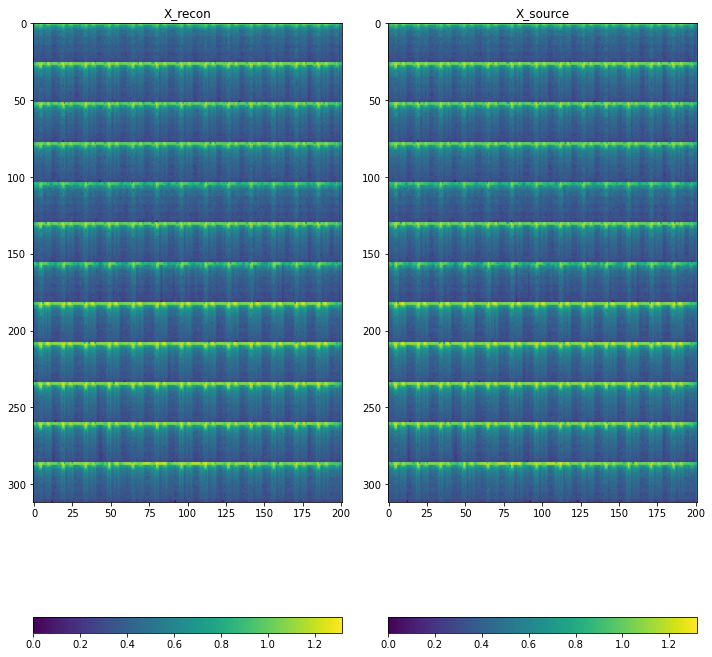

In [14]:
import torch.nn.functional as F

F.mse_loss(torch.Tensor([0.0, 0.0, 0.0]), torch.Tensor([0.3, 0.5, 0.6]))

n = torchaudio.transforms.Spectrogram(
    n_fft = 50,
    power = 0.1,
#     normalized=True
)
any(torch.isnan(n(torch.zeros(1, 12, 5000))).flatten())

x_source = n(torch.transpose(p_signal, 1, 2))
x_recon = n(torch.transpose(p_signal, 1, 2))

print(any(torch.isnan(x_source).flatten()))

# print(x_recon)
print(x_source[~torch.isnan(x_source)].shape)
print(x_recon[~torch.isnan(x_source)].shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 11))
ax[0].set_title("X_recon")
spec_recon = np.concatenate([x_recon[0, i, :, :].squeeze() for i in range(12)])
im = ax[0].imshow(spec_recon)
fig.colorbar(im, ax=ax[0], orientation="horizontal")
ax[1].set_title("X_source")
spec_source = np.concatenate([x_source[0, i, :, :].squeeze() for i in range(12)])
im = ax[1].imshow(spec_source)
fig.colorbar(im, ax=ax[1], orientation="horizontal")
fig.tight_layout()
plt.show()


## TorchAudio SPEECHCOMMANDS Dataset

In [15]:
ds = torchaudio.datasets.SPEECHCOMMANDS("data", download=True)

In [16]:
len(ds)

105829

In [17]:
waveform, sample_rate, utterance, speaker_id, utterance_id = ds[10]
waveform, sample_rate, utterance, speaker_id, utterance_id

(tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.0518e-05, 0.0000e+00,
          0.0000e+00]]),
 16000,
 'yes',
 '6ef407da',
 1)

In [18]:
waveform.shape


torch.Size([1, 16000])

In [19]:
display(Audio(data=waveform, rate=sample_rate))

(129,) (71,) (129, 71)


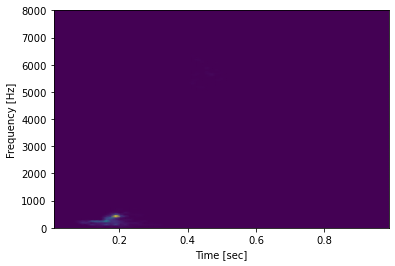

In [20]:
f, t, Sxx =signal.spectrogram(waveform.view(-1), fs=sample_rate)
print(f.shape, t.shape, Sxx.shape)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

torch.Size([1, 201, 81])


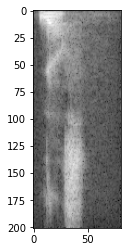

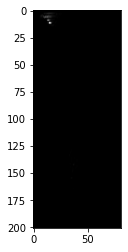

In [21]:
specgram = torchaudio.transforms.Spectrogram()(waveform)
plt.figure()
print(specgram.shape)
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap="gray")
plt.show()
plt.imshow(specgram[0,:,:].numpy(), cmap="gray")

### CinC2020 Beat Dataset Exploration

In [22]:
from functools import partial

import numpy as np
import scipy.signal as ss
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import neurokit2 as nk
from wfdb import rdrecord

from datasets.utils import walk_files, parse_comments


In [23]:
root = "data"
ecg_records = tuple(walk_files(root, suffix=".hea", prefix=True, remove_suffix=True))


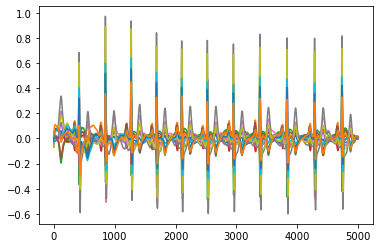

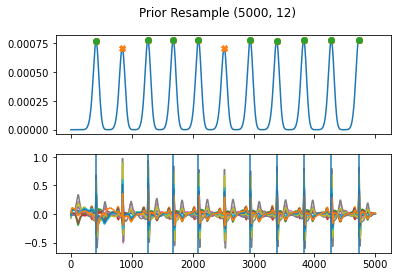

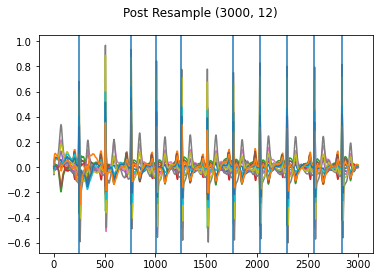

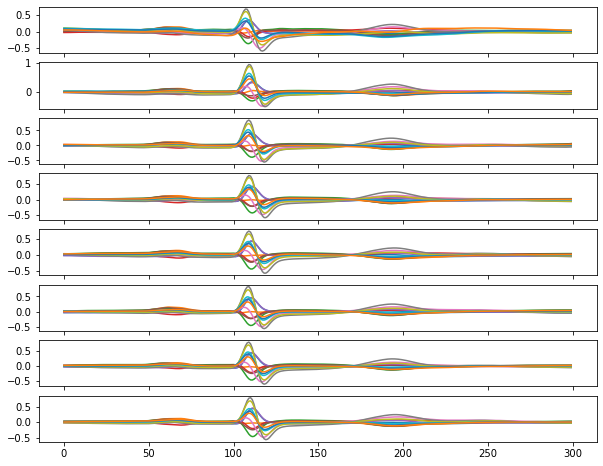

(8, 300, 12)


43099

In [437]:
def clean_ecg_nk2(ecg_signal, sampling_rate=500):
    """
    Parallelized version of neurokit2 ecg_clean(method="neurokit")
    ecg_signal shape should be (signal_length, number of leads)
    """
    # Remove slow drift with highpass Butterworth.
    sos = ss.butter(
        5,
        (0.5,),
        btype="highpass",
        output="sos",
        fs=sampling_rate,
    )
    clean = ss.sosfiltfilt(sos, ecg_signal, axis=0).T

    # DC offset removal with 50hz powerline filter (convolve average kernel)
    if sampling_rate >= 100:
        b = np.ones(int(sampling_rate / 50))
    else:
        b = np.ones(2)
    a = [
        len(b),
    ]
    clean = np.copy(ss.filtfilt(b, a, clean, method="pad", axis=1).T)

    return clean


def derive_rpeak_samples(ecg_record:str, pqrst_window_size: int = 300):
    """
    return window{0.35:0.65} window ranges around r-peak.
    resampled s.t. r-peak distance mean == window
    """
    record = rdrecord(ecg_record)
    age, sex, dx = parse_comments(record.comments)
    
    p_signal = record.p_signal
    sampling_rate = record.fs
    
    # clean the signal
    p_signal = clean_ecg_nk2(p_signal, sampling_rate)
   
    plt.plot(p_signal)
    plt.show()

    def nk_ecg_peaks(cleaned_signal):
        try:
            return nk.ecg_peaks(
                cleaned_signal,
                sampling_rate=sampling_rate,
                method="neurokit",
                correct_artifacts=True
            )
        except Exception:
            return None, {"ECG_R_Peaks": []}
        
    # determine the locations of each R-peak in all of the leads
    r_peaks_df, r_peak_dicts = zip(*map(nk_ecg_peaks, p_signal.T))
    # print(len(r_peak_dicts), r_peak_dicts)
    # join all of these locations into a single vector
    r_peaks = np.concatenate([
        r_peak_dict["ECG_R_Peaks"] for r_peak_dict in r_peak_dicts
    ])[:, np.newaxis]
    if len(r_peaks) == 0:
        raise Exception(f"{ecg_record}, No R-peaks detected in signal!")
    sig_range = np.linspace(0, r_peaks.max(), len(p_signal))[:, np.newaxis]

    # Find the peaks with bandwidth according to rough mean RR
    rough_meanrr = np.mean([
        np.diff(r_peak_dict["ECG_R_Peaks"]).mean()
        for r_peak_dict in r_peak_dicts
        if len(r_peak_dict["ECG_R_Peaks"]) >= 2
    ])
    # print(rough_meanrr)
    kde = KernelDensity(bandwidth=rough_meanrr/10).fit(r_peaks)
    log_dens = kde.score_samples(sig_range)
    dens = np.exp(log_dens)
    peaks, _ = ss.find_peaks(dens)

    # keep only the peaks that are greater than the mean density -  1std
    threshold_peak_density = dens[peaks].mean() - dens[peaks].std()
    valid_peaks = peaks[dens[peaks] > threshold_peak_density]

    # DISPLAY/DEBUGGING PURPOSES
    fig, axs = plt.subplots(2, sharex=True)
    axs[0].plot(sig_range[:, 0], dens)
    axs[0].plot(sig_range[peaks], dens[peaks], "X")
    axs[0].plot(sig_range[valid_peaks], dens[valid_peaks], "o")
    axs[1].plot(p_signal)
    fig.suptitle(f"Prior Resample {p_signal.shape}")
    for vpeak in sig_range[valid_peaks]:
        plt.axvline(x=vpeak)
    plt.show()

    # resample the signal such that the mean distance between 
    # valid R-peaks is equal to `pqrst_window_size`
    scaling_indicies = sig_range[valid_peaks].squeeze()
    scaling_indicies = np.insert(scaling_indicies, 0, 0)
    scaling_indicies = np.append(scaling_indicies, len(p_signal))
    peak_diff_dist = np.diff(scaling_indicies)
    mean_peak_diff_dist = peak_diff_dist.mean()
    resamp_to_len = (len(p_signal) / mean_peak_diff_dist) * pqrst_window_size
    resamp_to_len = int(np.ceil(resamp_to_len))
    p_signal = ss.resample(p_signal, resamp_to_len)
    # resample the peaks so we don't have to calculate again
    scaling_factor = pqrst_window_size / mean_peak_diff_dist
    upscaled_peak_diff_dist = peak_diff_dist * scaling_factor
    scaled_indicies = np.r_[scaling_indicies[0], upscaled_peak_diff_dist].cumsum()
    scaled_indicies = scaled_indicies[1:-1]

    # DISPLAY/DEBUGGING PURPOSES
    fig, axs = plt.subplots(1, sharex=True)
    axs.plot(p_signal)
    fig.suptitle(f"Post Resample {p_signal.shape}")
    for sc in scaled_indicies:
        plt.axvline(x=sc)
    plt.show()

    # slice up windows and return new matrices
    valid_windows = []
    sc_loffset = pqrst_window_size * 0.35
    for sc in scaled_indicies:
        left_offset = int(np.floor(sc-sc_loffset))
        scaled_window = p_signal[left_offset:left_offset + pqrst_window_size]
        if len(scaled_window) != pqrst_window_size:
            # ignore windows that don't fit into window size
            continue
        valid_windows.append(scaled_window)
        
    fig, axs = plt.subplots(len(valid_windows), sharex=True, figsize=(10, len(valid_windows)))
    for i in range(len(valid_windows)):
        axs[i].plot(valid_windows[i])
        # axs[i].plot(normalize(valid_windows[i].T).T)
    plt.show()
    
    print(np.stack(valid_windows).shape)

# derive_rpeak_samples(ecg_records[7]) # 7 is ugly
# derive_rpeak_samples(ecg_records[11])  # lots of peaks
# derive_rpeak_samples(ecg_records[9])
derive_rpeak_samples(ecg_records[13])

len(ecg_records)


### LSTM Beat Encoder Playground

In [25]:
# Loading Version 42, as it was the best Optuna discovered linear Auto-Encoder
all_optuna_out = list(walk_files("log_beat_autoencoder", suffix=".ckpt", prefix=True))
all_optuna_out

['log_beat_autoencoder/version_0/checkpoints/epoch=38.ckpt',
 'log_beat_autoencoder/version_1/checkpoints/epoch=5.ckpt',
 'log_beat_autoencoder/version_10/checkpoints/epoch=34.ckpt',
 'log_beat_autoencoder/version_104/checkpoints/epoch=37.ckpt',
 'log_beat_autoencoder/version_11/checkpoints/epoch=36.ckpt',
 'log_beat_autoencoder/version_111/checkpoints/epoch=38.ckpt',
 'log_beat_autoencoder/version_114/checkpoints/epoch=35.ckpt',
 'log_beat_autoencoder/version_116/checkpoints/epoch=38.ckpt',
 'log_beat_autoencoder/version_117/checkpoints/epoch=37.ckpt',
 'log_beat_autoencoder/version_12/checkpoints/epoch=26.ckpt',
 'log_beat_autoencoder/version_120/checkpoints/epoch=37.ckpt',
 'log_beat_autoencoder/version_125/checkpoints/epoch=36.ckpt',
 'log_beat_autoencoder/version_126/checkpoints/epoch=36.ckpt',
 'log_beat_autoencoder/version_128/checkpoints/epoch=0.ckpt',
 'log_beat_autoencoder/version_13/checkpoints/epoch=38.ckpt',
 'log_beat_autoencoder/version_130/checkpoints/epoch=33.ckpt',
 '

In [26]:
best = [v for v in all_optuna_out if "version_42" in v][0]
best

'log_beat_autoencoder/version_42/checkpoints/epoch=38.ckpt'

In [27]:
state_dict = torch.load(best)
# state_dict

import importlib
import linear_beat_autoencoder
importlib.reload(linear_beat_autoencoder)
beat_autoencoder = linear_beat_autoencoder.BeatAutoEncoder.load_from_checkpoint(best)

In [28]:
data_config = state_dict["hyper_parameters"]["data_config"]
print("train records:", len(data_config["train_records"].indices))
print("val records:", len(data_config["val_records"].indices))
print("test records:", len(data_config["test_records"].indices))


train records: 34479
val records: 4309
test records: 4311


In [29]:
state_dict.keys()
state_dict["hyper_parameters"]

"base_lr":           1e-05
"batch_size":        1024
"data_config":       {'train_records': <torch.utils.data.dataset.Subset object at 0x7f405c7c38b0>, 'val_records': <torch.utils.data.dataset.Subset object at 0x7f41a96cae20>, 'test_records': <torch.utils.data.dataset.Subset object at 0x7f40fc349310>}
"dropout":           0.10190683136936116
"embedding_dim":     386
"hidden_dim":        1939
"max_lr":            0.001
"momentum":          0.8921928775156637
"num_leads":         12
"pqrst_window_size": 400

In [30]:
beat_autoencoder

BeatAutoEncoder(
  (enc): Encoder(
    (enc): Sequential(
      (0): Flatten()
      (1): Linear(in_features=4800, out_features=1939, bias=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.10190683136936116, inplace=False)
      (4): Linear(in_features=1939, out_features=386, bias=True)
      (5): ReLU(inplace=True)
      (6): Dropout(p=0.10190683136936116, inplace=False)
    )
  )
  (dec): Decoder(
    (dec): Sequential(
      (0): Linear(in_features=386, out_features=1939, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.10190683136936116, inplace=False)
      (3): Linear(in_features=1939, out_features=4800, bias=True)
      (4): View()
      (5): Tanh()
    )
  )
)

In [31]:

SCORED_CODES = [
    270492004,  # ['IAVB', '1st degree av block']
    164889003,  # ['AF', 'atrial fibrillation']
    164890007,  # ['AFL', 'atrial flutter']
    426627000,  # ['Brady', 'bradycardia']
    713427006,  # ['CRBBB', 'complete right bundle branch block']
    713426002,  # ['IRBBB', 'incomplete right bundle branch block']
    445118002,  # ['LAnFB', 'left anterior fascicular block']
    39732003,  # ['LAD', 'left axis deviation']
    164909002,  # ['LBBB', 'left bundle branch block']
    251146004,  # ['LQRSV', 'low qrs voltages']
    698252002,  # ['NSIVCB', 'nonspecific intraventricular conduction disorder']
    10370003,  # ['PR', 'pacing rhythm']
    284470004,  # ['PAC', 'premature atrial contraction']
    427172004,  # ['PVC', 'premature ventricular contractions']
    164947007,  # ['LPR', 'Prolonged PR interval']
    111975006,  # ['LQT', 'prolonged qt interval']
    164917005,  # ['QAb', 'qwave abnormal']
    47665007,  # ['RAD', 'right axis deviation']
    59118001,  # ['RBBB', 'right bundle branch block']
    427393009,  # ['SA', 'sinus arrhythmia']
    426177001,  # ['SB', 'sinus bradycardia']
    426783006,  # ['SNR', 'sinus rhythm']
    427084000,  # ['STach', 'sinus tachycardia']
    63593006,  # ['SVPB', 'supraventricular premature beats']
    164934002,  # ['TAb', 't wave abnormal']
    59931005,  # ['TInv', 't wave inversion']
    17338001,  # ['VPB', 'ventricular premature beats']
]

class SequenceZarr(Dataset):
    """PyTorch Dataset class for returning sequences of beat windows."""

    def __init__(
        self,
        zarr_group_path: str = "data/ecgs.zarr",
        window_size: int = 400,
        sequence_length: int = 10,
        mlb_classes: List[int] = SCORED_CODES,
        record_idxs: Union[None, List[int]] = None,
    ):
        super().__init__()
        self.sequence_length = sequence_length
        self.window_size = window_size
        self.root = zarr.open_group(zarr_group_path, mode="r")
        if record_idxs is None:
            self.record_idxs = list(
                range(len(self.root[f"beats/window_size_{window_size}_normalized"]))
            )
        else:
            # Check that all of the provided record idxs are in range
            # assert all(record_id in list(
            #     range(len(self.root[f"beats/window_size_{window_size}_normalized"]))
            # ) for record_id in record_idxs)
            self.record_idxs = sorted(record_idxs)

        self.mlb = MultiLabelBinarizer(classes=mlb_classes)

    def __len__(self):
        return len(self.record_idxs)

    def __getitem__(self, idx):
        record_idx = self.record_idxs[idx]
        # Get the normalized beat windows and the outlier index
        beat_windows = self.root[f"beats/window_size_{self.window_size}_normalized"][
            record_idx
        ].reshape(
            self.root[f"beats/window_size_{self.window_size}_shape"][record_idx],
            order="C",
        )
        outlier = self.root[f"beats/window_size_{self.window_size}_outlier"][record_idx]

        # Return a sequence of `sequence_length` beat windows, containin the outlier in the middle
        start_idx = 0
        end_idx = len(beat_windows) - 1

        # if sequence length is greater than length of beat_windows, return entire beat_windows
        if self.sequence_length < len(beat_windows):
            # return a sequence that contains the outlier beat (try to put it in the middle of the array)
            half_len = self.sequence_length // 2
            if outlier - half_len in range(len(beat_windows)):
                start_idx = outlier - half_len
                end_offset = 0
            else:
                # cannot place outlier in the 'middle', offset end
                end_offset = abs(outlier - half_len)

            if outlier + half_len + end_offset in range(len(beat_windows)):
                end_idx = outlier + half_len + end_offset
            else:
                # cannot outlier in the middle, offset start
                end_idx = len(beat_windows) - 1
                start_idx = end_idx - self.sequence_length

        # make writeable
        beat_seq = np.array(beat_windows[start_idx:end_idx])
        del beat_windows

        # change all nan to 0
        np.nan_to_num(beat_seq, copy=False)

        # get the dx and return sparse y_indicator
        dx = self.root["raw/dx"][record_idx]
        sparse_dx = self.mlb.fit_transform([dx, ])[0]

        return beat_seq, sparse_dx

    @staticmethod
    def collate_fn(batch):
        # custom collate function to support variable length inputs
        data_len_dxs = [(torch.Tensor(s[0]), len(s[0]), s[1]) for s in batch]

        # sort such that lengths are from longest to shortest
        data, lengths, dxs = zip(*sorted(data_len_dxs, key=itemgetter(1), reverse=True))
        return [data, lengths, dxs]


ds = SequenceZarr()
# ds[9].shape # less than 10 beats?
# ds[0]

In [32]:
ds_col = SequenceZarr(record_idxs=data_config["train_records"])
dl_col = DataLoader(ds_col, batch_size=7, collate_fn = SequenceZarr.collate_fn)
iter_dl = iter(dl_col)

In [33]:
class SequenceAutoEncoder(nn.Module):
    def __init__(
        self,
        bae_checkpoint_path:str,
        input_size=386,
        hidden_size=386,
        num_layers=2
    ):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.beat_autoencoder = linear_beat_autoencoder.BeatAutoEncoder.load_from_checkpoint(
            bae_checkpoint_path
        )
        self.lstm_enc = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers
        )
        self.lstm_dec = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers
        )
    
    def forward(self, x):
        # x is arbitrary length beat window sequences
        bw, lstm_input_lengths = x

        # Convert into beat autoencoder embedding
        raw_seq_enc_input, _recon = zip(*map(self.beat_autoencoder, bw))
        # lstm_input_lengths = [len(inp) for inp in raw_seq_enc_input]

        max_seq_length = max(lstm_input_lengths)
        # batch_size = len(raw_seq_enc_input)

        # pack variable length sequences for batched LSTM encoder training
        seq_enc_input = pack_sequence(raw_seq_enc_input)
        _seq_enc_outputs, (h_n, c_n) = self.lstm_enc(seq_enc_input)
        # seq_unpacked, lens_unpacked = pad_packed_sequence(lstm_enc_out)
        # length_idxs = [i - 1 for i in lens_unpacked]
        # batch_idxs = [i for i in range(batch_size)]
        # Bottleneck representation of sequences
        # seq_bottleneck = seq_unpacked[length_idxs, batch_idxs, :]
        # print(all((h_n[-1] == seq_bottleneck).flatten()))
        seq_bottleneck = h_n[-1]  # equivalent to all commented out code

        # rebuild the input using lstm decoder
        rebuild_hidden = torch.zeros_like(h_n), torch.zeros_like(c_n)
        rebuild_next = torch.unsqueeze(seq_bottleneck, 0)
        recon_seq = []
        for idx in range(max_seq_length):
            rebuild_next, rebuild_hidden = self.lstm_dec(rebuild_next, rebuild_hidden)
            recon_seq.append(rebuild_next)

        # full reconstructed sequence, slice to batch beat window lengths
        recon_seq = torch.cat(recon_seq, dim=0)
        bw_outputs = []
        for idx, length in enumerate(lstm_input_lengths):
            bw_outputs.append(recon_seq[0:length, idx, :])
        #         print(len(bw_outputs))
        #         print([bwo.shape for bwo in bw_outputs])

        return seq_bottleneck, raw_seq_enc_input, bw_outputs

In [34]:
m = SequenceAutoEncoder(best)
# print(m)
model_inputs, lengths, dxs = next(iter_dl)
# print(model_inputs, lengths)
# for model_input in model_inputs:
#     print(model_input.shape, type(model_input))
#     #print(model_input)
#     m.beat_autoencoder(model_input)
bottleneck, enc_input, enc_output = m((model_inputs, lengths))
print(bottleneck.shape, len(enc_output))

def loss_function(recon_x, source_x):
    # recon_x and x are lists of tensors, each element is a sample
    # the entire list being the batch
#     print(source_x)
    sq_err = torch.sum(torch.stack(
        [
            F.mse_loss(r_x, s_x, reduction="sum")
            for r_x, s_x in zip(recon_x, source_x)
        ]
    ))

    return sq_err / len(recon_x)

loss_function(enc_output, enc_input)

torch.Size([7, 386]) 7


/home/alexwong/miniconda3/envs/msc_research/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:994: UserWarning: unknown class(es) [164867002] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/home/alexwong/miniconda3/envs/msc_research/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:994: UserWarning: unknown class(es) [164867002, 428750005] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/home/alexwong/miniconda3/envs/msc_research/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:994: UserWarning: unknown class(es) [164861001, 428750005] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/home/alexwong/miniconda3/envs/msc_research/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:994: UserWarning: unknown class(es) [428750005] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/home/alexwong/miniconda3/envs/msc_research/lib/python3.8/site-packages/sklearn/pr

tensor(13.4733, grad_fn=<DivBackward0>)

In [443]:
# torch.stack([s[:2, :] for s in enc_input]).flatten(1).shape
# [dx.argmax() for dx in dxs]
# bottleneck.shape
len(SCORED_CODES)

def class_loss_function(y_hat, y, weight=None):
    if weight:
        return F.multilabel_soft_margin_loss(
            y_hat, y, weight=weight, reduction="sum"
        )
    return F.multilabel_soft_margin_loss(y_hat, y, reduction="sum")

# class_loss_function(torch.rand(20, 20), torch.eye(20))

print(class_loss_function(torch.eye(20), torch.eye(20)))
print(class_loss_function(F.tanh(torch.eye(20)), torch.eye(20)))
print(class_loss_function(F.sigmoid(torch.eye(20)), torch.eye(20)))

print(class_loss_function(torch.ones(20, 20) * -7, torch.ones(20, 20)))
print(class_loss_function(F.tanh(torch.ones(20, 20) * -7), torch.ones(20, 20)))
print(class_loss_function(F.sigmoid(torch.ones(20, 20) * -7), torch.ones(20, 20)))

# torch.eye(20).shape
# F.tanh(torch.eye(20))

tensor(13.4831)
tensor(13.5530)
tensor(18.9005)
tensor(140.0182)
tensor(26.2652)
tensor(13.8538)


/home/alexwong/miniconda3/envs/msc_research/lib/python3.8/site-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/alexwong/miniconda3/envs/msc_research/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


### Beat Encoder Exploring

In [439]:
ds = SequenceZarr(record_idxs=data_config["train_records"])
dl = DataLoader(ds, batch_size=1)

In [503]:
a, b = next(iter(dl))
a.shape, len(b)

class ExploringBeatEncoder(nn.Module):
    def __init__(self, dropout:float=0.1, embedding_dim:int=386):
        super().__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv1d(12, 16, 164),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Conv1d(16, 20, 128),
            nn.BatchNorm1d(20),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Conv1d(20, 24, 64),
            nn.BatchNorm1d(24),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
        )
        # torch.Size([n, 24, 47]), 1128
        self.embedder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1128, embedding_dim)
        )

    def forward(self, x):
        # batch, window_len, num_channels
        x = torch.transpose(x, 1, 2)
        # batch, num_channels, window_len
        out = self.conv_block(x)
        out = self.embedder(out)
        return out
        

b_model = ExploringBeatEncoder()

beat_inp = torch.rand((1, 400, 12))
print(f"inp shape: {beat_inp.shape}; num params: {np.prod(beat_inp.shape)}")
output = b_model(beat_inp)
print(f"out shape: {output.shape}; num params: {np.prod(output.shape)}")

print("encoder params", sum(dict((p.data_ptr(), p.numel()) for p in b_model.parameters()).values()))


inp shape: torch.Size([1, 400, 12]); num params: 4800
out shape: torch.Size([1, 386]); num params: 386
encoder params 539142


192

In [532]:
foo_stub = torch.rand(9, 27) * 0.01
ck_stub = foo_stub > torch.rand(27)
ck_stub.any(dim=0)
print(ck_stub.shape)
for sample_idx, has_one in enumerate(ck_stub.any(dim=1)):
    print(sample_idx, has_one)
    if has_one:
        continue
    ck_stub[sample_idx, foo_stub[sample_idx].argmax()] = True
    print(foo_stub[sample_idx].argmax())
ck_stub

torch.Size([9, 27])
0 tensor(False)
tensor(2)
1 tensor(False)
tensor(0)
2 tensor(False)
tensor(19)
3 tensor(False)
tensor(7)
4 tensor(False)
tensor(21)
5 tensor(False)
tensor(1)
6 tensor(False)
tensor(18)
7 tensor(False)
tensor(8)
8 tensor(False)
tensor(1)


tensor([[False, False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False],
        [ True, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False,  True, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fa